## IMPORTING LIBRARIES

In [ ]:
# nltk is one of the most useful libraries when it comes to nlp
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud
import plotly.express as px
from plotly.subplots import make_subplots

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

### LOADING DATASET

In [ ]:
df = pd.read_excel('/content/hotel_reviews.xlsx')
df.head(100)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4.0
1,ok nothing special charge diamond member hilto...,2.0
2,nice rooms not 4* experience hotel monaco seat...,3.0
3,"unique, great stay, wonderful time hotel monac...",5.0
4,"great stay great stay, went seahawk game aweso...",5.0
...,...,...
95,"excellent stay staff friendly helpful, nice ho...",4.0
96,return going seattle booked hotel knowing budg...,4.0
97,terrible hotel approximately 2 weeks ago april...,1.0
98,great price okay experience stayed inn queen a...,3.0


In [ ]:
df2 = df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  20491 non-null  object 
 1   Rating  20491 non-null  float64
dtypes: float64(1), object(1)
memory usage: 320.3+ KB


As you can see from above details, there is **no null values** in this dataset

#EDA AND TEXT PREPROCESSING

In [ ]:
# Count reviews by Rating
x = df.Rating.value_counts().reset_index().rename(columns={'index': 'Rating', 'Rating': 'Count'})
fig = px.bar(x, 
             x="Rating", 
             y="Count", 
             color="Rating", 
             color_continuous_scale=["#EF553B", "#FFA15A", "#FECB52", "#B6E880", "#00CC96"],
             title="Reviews by rating"
            )


fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    margin=dict(l=0,r=0,b=0)
)

fig.update_layout(coloraxis_showscale=False)

fig.show()

In [ ]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4.0,593
1,ok nothing special charge diamond member hilto...,2.0,1689
2,nice rooms not 4* experience hotel monaco seat...,3.0,1427
3,"unique, great stay, wonderful time hotel monac...",5.0,600
4,"great stay great stay, went seahawk game aweso...",5.0,1281


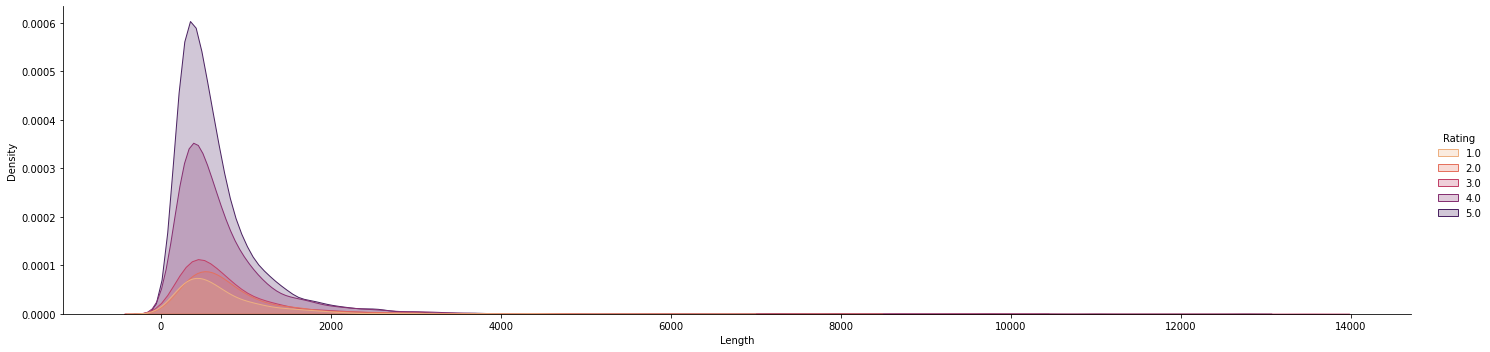

In [ ]:
sns.displot(data=df, x='Length', hue='Rating', palette='flare', kind='kde', fill=True, aspect=4)

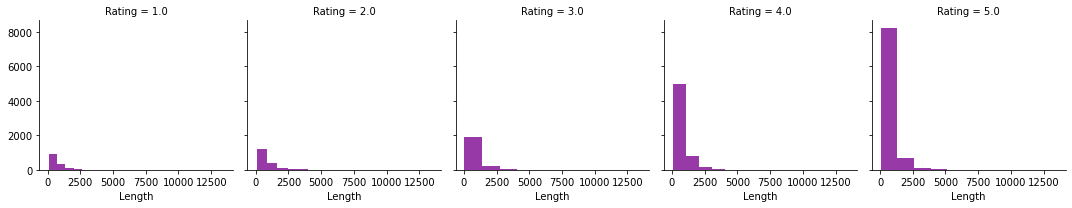

In [ ]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length', color='#973aa8')

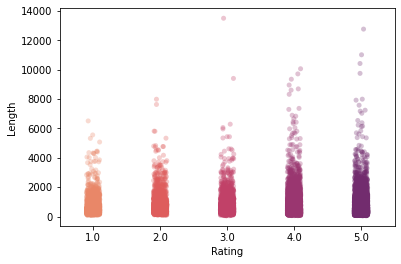

In [ ]:
sns.stripplot(data=df, x='Rating', y='Length', palette='flare', alpha=0.3)

From above plot we can say that **the higher the rating of the hotel, the more likely the visitors wrote a long review**

In [ ]:
# Let's change the rating to be more general and easier to understand
def ratings(score):
    if score > 3:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

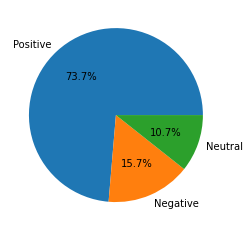

In [ ]:
df['Rating'] = df['Rating'].apply(ratings)
plt.pie(df['Rating'].value_counts(), labels=df['Rating'].unique().tolist(), autopct='%1.1f%%')
plt.show()



> Positive reviews = 73.7%

> Negative reviews = 15.7%

> Neutral reviews = 10.7%







In [ ]:
df.head(20)

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,Positive,593
1,ok nothing special charge diamond member hilto...,Negative,1689
2,nice rooms not 4* experience hotel monaco seat...,Neutral,1427
3,"unique, great stay, wonderful time hotel monac...",Positive,600
4,"great stay great stay, went seahawk game aweso...",Positive,1281
5,love monaco staff husband stayed hotel crazy w...,Positive,1002
6,"cozy stay rainy city, husband spent 7 nights m...",Positive,748
7,"excellent staff, housekeeping quality hotel ch...",Positive,597
8,"hotel stayed hotel monaco cruise, rooms genero...",Positive,419
9,excellent stayed hotel monaco past w/e delight...,Positive,271


In [ ]:
# Total word in dataset before cleaning
length = df['Length'].sum()
length

14861007

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.tokenize import TweetTokenizer, word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

def create_corpus_df(df):
    corpus = []
    
    
    for i in range(df.shape[0]):
        words = word_tokenize(df.loc[i, 'Review'])
        rating = df.loc[i, 'Rating']
        
        for w in words:
            corpus.append([w, rating])
            
    return np.asarray(corpus)

In [ ]:
corpus = create_corpus_df(df)

In [ ]:
corpus_df = pd.DataFrame(corpus, columns=['token', 'rating'])

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Top common stopwords</span></b></h1>

In [ ]:
def get_stopwords_from_corpus(corpus_df, n=10):
    stop = set(stopwords.words('english'))
    
    corpus_stop_df = corpus_df[corpus_df['token'].isin(stop)].copy()
    
    corpus_stop_df['count'] = 1
    
    corpus_stop_df = corpus_stop_df.groupby(by=['token', 'rating']).count().reset_index().sort_values('count', ascending=False)

    tokens = corpus_stop_df['token'].unique().tolist()[:n]
        
    return corpus_stop_df[corpus_stop_df['token'].isin(tokens)]

In [ ]:
color_map = {
                "1": "#EF553B",
                "2": "#FFA15A",
                "3": "#FECB52",
                "4": "#B6E880",
                "5": "#00CC96"
            }

In [ ]:
x = get_stopwords_from_corpus(corpus_df, n=5)

fig = px.bar(x, 
             x="token", 
             y="count", 
             color="rating", 
             color_discrete_map=color_map,
             title="Top common stopwords"
            )


fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(l=0,r=0,b=0),
    barmode='group'
)

fig.show()

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Top common words</span></b></h1>

In [ ]:
def get_common_words_from_corpus(corpus_df, n_top=20):
    stop = set(stopwords.words('english'))
    puncts = word_tokenize(string.punctuation)
    
    corpus_stop_df = corpus_df[(~corpus_df['token'].isin(stop)) & (~corpus_df['token'].isin(puncts))].copy()
    
    corpus_stop_df['count'] = 1
    
    corpus_stop_df = corpus_stop_df.groupby(by=['token', 'rating']).count().reset_index().sort_values('count', ascending=False)

    tokens = corpus_stop_df['token'].unique().tolist()[:n_top]
    
    return corpus_stop_df[corpus_stop_df['token'].isin(tokens)]

In [ ]:
x = common_words = get_common_words_from_corpus(corpus_df, n_top=10)

fig = px.bar(x, x="token", y="count", color="rating", color_discrete_map=color_map, title="Top common words")


fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0,r=0,b=0),
    barmode='group'
)                                                                                       

fig.show()

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Common punctuation count</span></b></h1>

In [ ]:
def get_common_punctuations_from_corpus(corpus_df):
    puncts = word_tokenize(string.punctuation)
    
    corpus_stop_df = corpus_df[corpus_df['token'].isin(puncts)].copy()
    
    corpus_stop_df['count'] = 1
    
    corpus_stop_df = corpus_stop_df.groupby(by=['token', 'rating']).count().reset_index().sort_values('count', ascending=False)
    
    return corpus_stop_df

In [ ]:
x = get_common_punctuations_from_corpus(corpus_df)

x.groupby('token')['count'].sum()

token
'        63
*       680
+        10
,    246646
:         1
`        95
Name: count, dtype: int64

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Lemmatize the word</span></b></h1>

In [ ]:
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

There are some difference among those 3 sentences, for instance:
* Original -> got, arrived
* Stemming -> got, arriv
* Lemmatization -> get, arrive

This time, we will use Lemmatization in order to get the base form of the word

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Stemming vs Lemmatization</b></h1>

I think this picture can give you a sense of what is the different between stemming and lemmatization

![image](https://stringfixer.com/files/107654628.jpg)

In [ ]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [ ]:
df['Review'] = df['Review'].apply(cleaning)

In [ ]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()
print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 14861007
Total text length after cleaning: 13548729


In [ ]:
df.to_csv('cleaned_df.csv', index=False)

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Remove Punctuation</span></b></h1>

In [ ]:
def remove_punctuation(df1):
    
    # remove punctuations
    table = str.maketrans('', '', string.punctuation)
    df1['Review'] = df1['Review'].str.translate(table)
    
    # remove extra spaces '  '
    df1['Review'] = df1['Review'].replace(r'\s\s+', ' ', regex=True)
    
    return df1

In [ ]:
df1 = remove_punctuation(df2)

In [ ]:
%%time
corpus = df1['Review'].apply(word_tokenize).tolist()
len(corpus), df.shape[0]

CPU times: user 9.63 s, sys: 278 ms, total: 9.91 s
Wall time: 9.93 s


(20491, 20491)

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Creating Bi-gram and Tri-gram</span></b></h1>

In [ ]:
corpus = np.asarray(corpus)
targets = np.asarray(df1['Rating'].tolist())

<ipython-input-35-bb2af6c8aa3c>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [ ]:
%%time
corpus_1 = df1[df1['Rating'] == 1]['Review'].apply(word_tokenize).tolist()
corpus_2 = df1[df1['Rating'] == 2]['Review'].apply(word_tokenize).tolist()
corpus_3 = df1[df1['Rating'] == 3]['Review'].apply(word_tokenize).tolist()
corpus_4 = df1[df1['Rating'] == 4]['Review'].apply(word_tokenize).tolist()
corpus_5 = df1[df1['Rating'] == 5]['Review'].apply(word_tokenize).tolist()

CPU times: user 9.91 s, sys: 447 ms, total: 10.4 s
Wall time: 10.4 s


In [ ]:
def count_n_grams(corpus, n=2, n_top=None):
    n_grams = {}
    
    for review in corpus:
        review = tuple(review)
        
        for i in range(0, len(review) - n + 1): 
                # Get the n-gram from i to i+n
                n_gram = review[i:i+n]
                
                # check if the n-gram is in the dictionary
                if n_gram in n_grams:
                    # Increment the count for this n-gram
                    n_grams[n_gram] += 1
                else:
                    # Initialize this n-gram count to 1
                    n_grams[n_gram] = 1
                    
    n_grams = pd.DataFrame.from_dict(n_grams, orient='index', columns=['count']).sort_values('count', ascending=False)
    
    n_grams.reset_index(inplace=True)
    
    n_grams['index'] = n_grams['index'].str.join(', ')
    
    
    if (n_top):
        n_grams = n_grams[:n_top]    
        
    return n_grams
    

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Bi-Gram</span></b></h1>

In [ ]:
%%time
bi_grams_1 = count_n_grams(corpus_1, n_top=10)
bi_grams_2 = count_n_grams(corpus_2, n_top=10)
bi_grams_3 = count_n_grams(corpus_3, n_top=10)
bi_grams_4 = count_n_grams(corpus_4, n_top=10)
bi_grams_5 = count_n_grams(corpus_5, n_top=10)

bi_grams_1['Rating'] = 1
bi_grams_2['Rating'] = 2
bi_grams_3['Rating'] = 3
bi_grams_4['Rating'] = 4
bi_grams_5['Rating'] = 5

bi_grams = pd.concat([bi_grams_5, bi_grams_4, bi_grams_3, bi_grams_2, bi_grams_1])

CPU times: user 3.88 s, sys: 320 ms, total: 4.2 s
Wall time: 4.22 s


In [ ]:
fig = px.bar(bi_grams, x="index", y="count", color="Rating", facet_col="Rating",  color_continuous_scale=["#EF553B", "#FFA15A", "#FECB52", "#B6E880", "#00CC96"])
fig.update_xaxes(matches=None)
fig.update_layout(coloraxis_showscale=False)
fig.show()

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Tri-Gram</span></b></h1>

In [ ]:
%%time
tri_grams_1 = count_n_grams(corpus_1, n=3, n_top=10)
tri_grams_2 = count_n_grams(corpus_2, n=3, n_top=10)
tri_grams_3 = count_n_grams(corpus_3, n=3, n_top=10)
tri_grams_4 = count_n_grams(corpus_4, n=3, n_top=10)
tri_grams_5 = count_n_grams(corpus_5, n=3, n_top=10)

tri_grams_1['Rating'] = 1
tri_grams_2['Rating'] = 2
tri_grams_3['Rating'] = 3
tri_grams_4['Rating'] = 4
tri_grams_5['Rating'] = 5

tri_grams = pd.concat([tri_grams_5, tri_grams_4, tri_grams_3, tri_grams_2, tri_grams_1])

CPU times: user 4.26 s, sys: 392 ms, total: 4.65 s
Wall time: 4.67 s


<timed exec>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = px.bar(tri_grams, x="index", y="count", color="Rating", facet_col="Rating", color_continuous_scale=["#EF553B", "#FFA15A", "#FECB52", "#B6E880", "#00CC96"])
fig.update_xaxes(matches=None)
fig.update_layout(coloraxis_showscale=False)
fig.show()

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Wordcloud</span></b></h1>

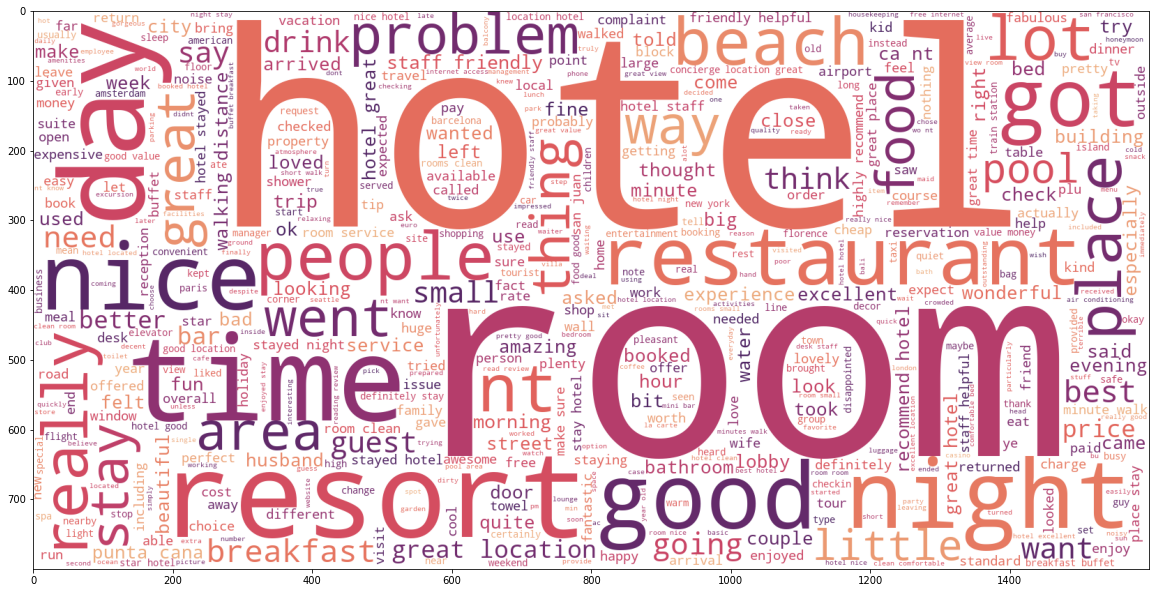

In [ ]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df1['Review']))

plt.imshow(wc)

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Creating Wordcloud for each Rating</span></b></h1>

In [ ]:
stops = stopwords.words('english') + ['hotel', 'room', 'not']

w1 = WordCloud(color_func=lambda *args, **kwargs: "#EF553B", 
               background_color='white', 
               max_words=50, 
               stopwords=stops,
               random_state=42,
               height=1000, 
               width=1000) \
            .generate(" ".join(df1[df1['Rating'] == 1]['Review']))

w2 = WordCloud(color_func=lambda *args, **kwargs: "#FFA15A", 
               background_color='white', 
               max_words=50, 
               stopwords=stops,
               random_state=42,
               height=1000, 
               width=1000) \
            .generate(" ".join(df1[df1['Rating'] == 2]['Review']))

w3 = WordCloud(color_func=lambda *args, **kwargs: "#FECB52", 
               background_color='white', 
               max_words=50, 
               stopwords=stops,
               random_state=42,
               height=1000, 
               width=1000) \
            .generate(" ".join(df1[df1['Rating'] == 3]['Review']))

w4 = WordCloud(color_func=lambda *args, **kwargs: "#B6E880", 
               background_color='white', 
               max_words=50, 
               stopwords=stops,
               random_state=42,
               height=1000, 
               width=1000) \
            .generate(" ".join(df1[df1['Rating'] == 4]['Review']))

w5 = WordCloud(color_func=lambda *args, **kwargs: "#00CC96", 
               background_color='white', 
               max_words=50,
               stopwords=stops,
               random_state=42,
               height=1000, 
               width=1000) \
            .generate(" ".join(df1[df1['Rating'] == 5]['Review']))



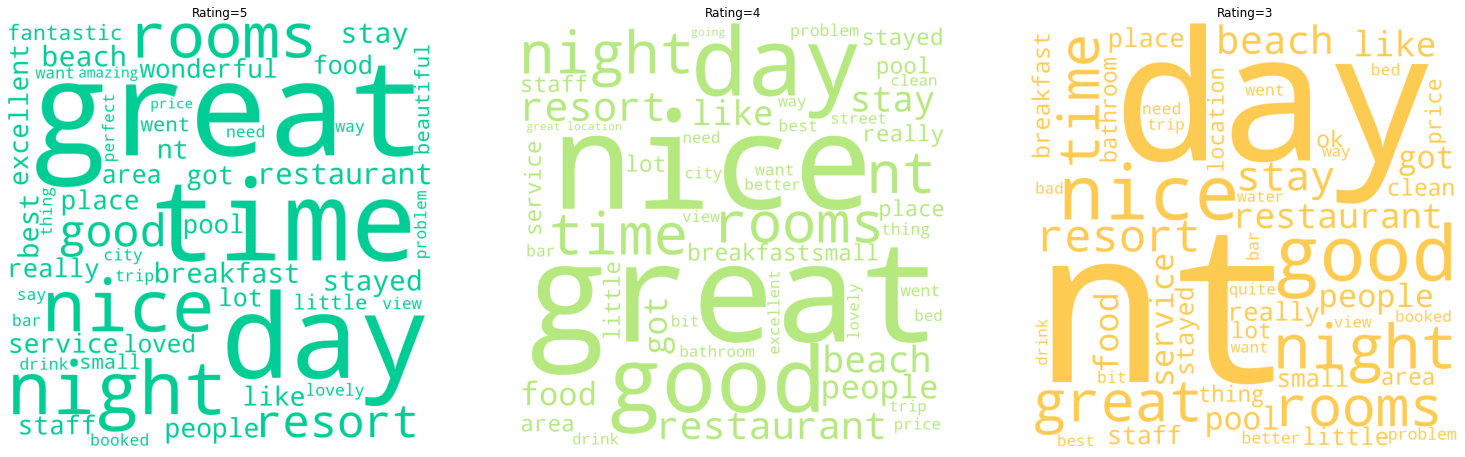

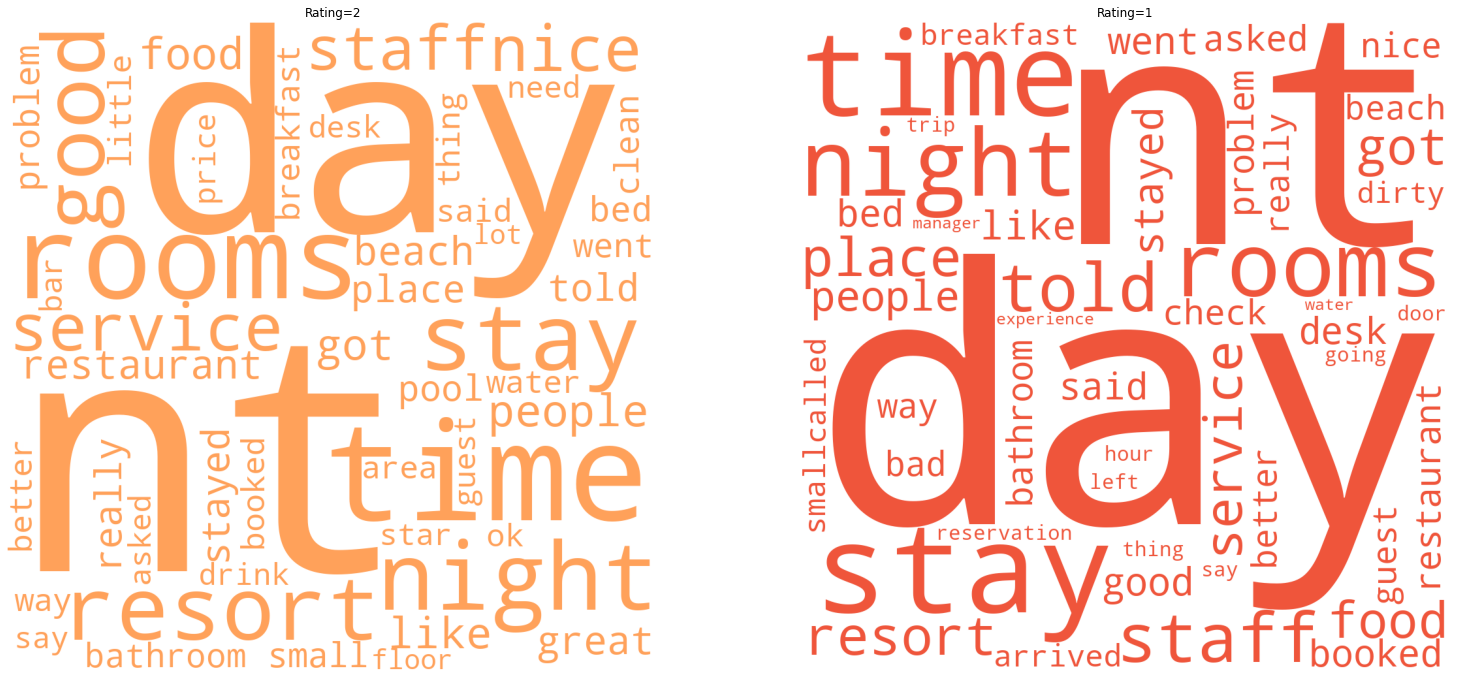

In [ ]:
fig = plt.figure(figsize=(26, 12))

fig.add_subplot(1, 3, 1)
plt.axis('off')
plt.title('Rating=5')
plt.imshow(w5)

fig.add_subplot(1, 3, 2)
plt.title('Rating=4')
plt.axis('off')
plt.imshow(w4)

fig.add_subplot(1, 3, 3)
plt.axis('off')
plt.title('Rating=3')
plt.imshow(w3)

fig = plt.figure(figsize=(26, 12))


fig.add_subplot(1, 2, 1)
plt.title('Rating=2')
plt.axis('off')
plt.imshow(w2)

fig.add_subplot(1, 2, 2)
plt.title('Rating=1')
plt.axis('off')
plt.imshow(w1)

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Train-Test-Split</span></b></h1>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">BUILDING MODEL WITH SKLEARN</span></b></h1>

In [ ]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [ ]:
pickle.dump(tfid, open('tfidf.pkl', 'wb'))

In [ ]:
from sklearn.linear_model import RidgeClassifier

In [ ]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB(),
          RidgeClassifier()]

In [ ]:
"""accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val)"""

In [ ]:
"""models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB', 'RidgeClassifier']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})                            
acc"""

,Model,Accuracy
0,DecisionTreeClassifier,0.740118
1,RandomForestClassifier,0.778551
2,SVC,0.854747
3,LogisticRegression,0.858590
4,KNeighborsClassifier,0.777574
5,BernoulliNB,0.751281
6,RidgeClassifier,0.855905


Since Logistic Regression performs better than other models in this case, we will use it to train our model

In [ ]:
fig = px.funnel(acc, x=models_name, y="Accuracy")
fig.show()

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Finalize the LogisticRegression model</span></b></h1>

In [ ]:
log = LogisticRegression(max_iter=1000)
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Creating pickle file for Deployment</span></b></h1>

In [ ]:
pickle.dump(log, open('ml_model.pkl', 'wb'))

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Creating function for prediction</span></b></h1>

In [ ]:
ml = pickle.load(open('ml_model.pkl','rb'))
tfidf = pickle.load(open('tfidf.pkl','rb'))
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfidf.transform([clean_text])
    pred_proba = ml.predict_proba(tfid_matrix)
    idx = np.argmax(pred_proba)
    pred = ml.classes_[idx]
    
    return pred, pred_proba[0][idx]

ml_predict("room service is good but staff is rude")

('Negative', 0.8704957473126589)

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">Classification Report and Confussion Matrix</span></b></h1>

              precision    recall  f1-score   support

    Negative       0.79      0.73      0.76       622
     Neutral       0.55      0.20      0.30       454
    Positive       0.88      0.98      0.93      3023

    accuracy                           0.86      4099
   macro avg       0.74      0.64      0.66      4099
weighted avg       0.83      0.86      0.83      4099



Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression Model')

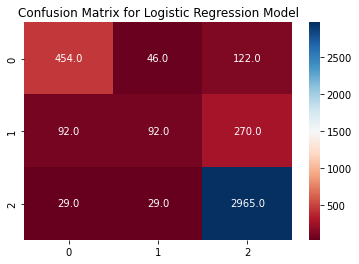

In [ ]:
cm = confusion_matrix(y_test, pred)
print(classification_report(y_test, pred))

sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for Logistic Regression Model")

<a id="7"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">PREDICTION</span></b></h1>

Let's make some prediction using the model we have trained. You can create your own reviews and let the model predict the sentiment in your text

In [ ]:
def ml_predict(text):                                                                       
    clean_text = cleaning(text)
    tfid_matrix = tfid.transform([clean_text])
    pred_proba = ml.predict_proba(tfid_matrix)
    pred = log.predict(tfid_matrix)[0]
    
    return pred

In [ ]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text)))

Prediction using Logistic Regression: Positive


In [ ]:
text2 = 'Awful room services and slow wifi connection'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text2)))

Prediction using Logistic Regression: Negative


In [ ]:
text3 = 'overall experience is nice but only wifi connection is very bad'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text3)))


Prediction using Logistic Regression: Neutral


In [ ]:
text4 = df['Review'][27]
print('Prediction using Logistic Regression: {}'.format(ml_predict(text4)))
text4

Prediction using Logistic Regression: Neutral


'meet expectations centrally locate hotel block water popular nightlife shop options belltown downtown classify property star location pay wed rate sure fare value proposition room spacious little outdated room decent view lower floor drab panaroma park lot build adequate fitness center sauna pool basement quaint barrestaurant attach hotel park 30 day outrage possibly standard downtown street park weekend save dollars will stay future price significantly lower nearby fourstar competition'